In [1]:
# 对/lustre/home/hangqian/data/zircons/Roberts_Spencer_2015.csv的贝叶斯拐点分析
# time bins个数：400
# 拐点个数：1
# 每核采样数：20000
# 每核burn数：1000（默认）

In [2]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

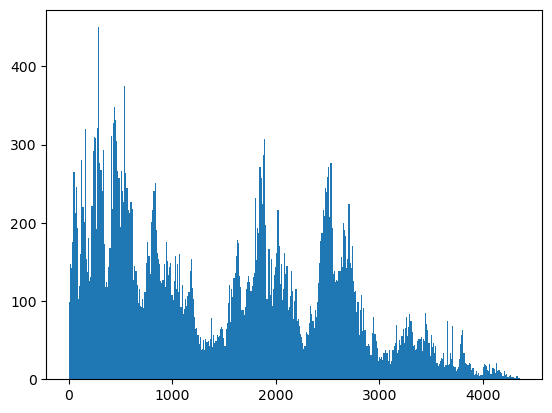

In [3]:
import math
import numpy as np
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy.stats import poisson
from patsy import dmatrices
import statsmodels.graphics.tsaplots as tsa
from matplotlib import pyplot as plt
from statsmodels.tools.numdiff import approx_hess1, approx_hess2, approx_hess3
import pandas as pd

df = pd.read_csv('/lustre/home/hangqian/data/zircons/Roberts_Spencer_2015.csv')
ages = df["U-Pb (Ma)"]
data = plt.hist(ages, bins = 400)

In [4]:
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.7.1


In [5]:
print(data)
print(type(data[0]),type(data[1]))

(array([ 99., 147., 142., 175., 265., 212., 246., 193., 102., 119., 160.,
       280., 220., 201., 320., 154., 137., 180., 126., 131., 221., 292.,
       310., 309., 192., 321., 450., 277., 268., 241., 293., 173., 118.,
       124., 118., 144., 168., 311., 218., 327., 348., 332., 305., 266.,
       257., 195., 266., 241., 227., 375., 264., 244., 216., 212., 226.,
       226., 218., 127., 145., 139., 120.,  97., 115.,  94.,  93., 102.,
        91., 111., 149., 175., 158., 158., 134., 201., 217., 241., 251.,
       191., 161., 154., 148., 126., 123., 127., 148., 118., 175., 151.,
       133., 144., 149., 108., 101., 126., 158., 115., 147., 112., 160.,
        93., 120.,  83.,  90., 102.,  94., 107., 112., 139., 154., 117.,
       103.,  80.,  64.,  65.,  57.,  45.,  54.,  38.,  39.,  50.,  38.,
        52.,  48.,  49.,  43.,  51.,  78.,  41.,  56.,  47.,  49.,  56.,
        54.,  55.,  64.,  67.,  64.,  53.,  42.,  64.,  72.,  98., 120.,
        73., 115., 105., 129., 136., 158., 178., 1

In [6]:
zircons_data = data[0]
ages = data[1][1:]

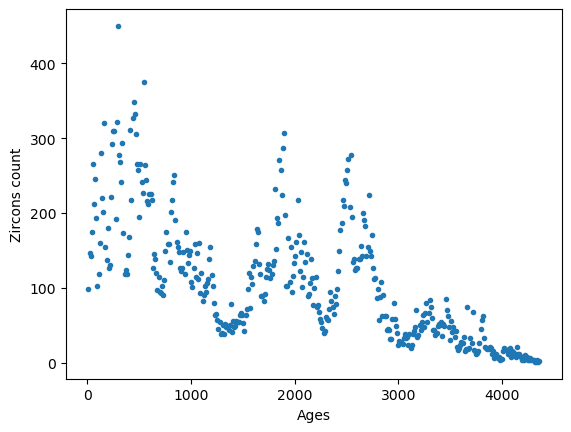

In [7]:
plt.plot(ages, zircons_data, "o", markersize=3, alpha=1)
plt.ylabel("Zircons count")
plt.xlabel("Ages");

In [8]:
ages_nominal = np.arange(len(ages))

In [9]:
with pm.Model() as zircons_model:
    switchpoint = pm.DiscreteUniform("switchpoint", lower=ages_nominal.min(), upper=ages_nominal.max())

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential("early_rate", 1.0)
    late_rate = pm.Exponential("late_rate", 1.0)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= ages_nominal, early_rate, late_rate)

    disasters = pm.Poisson("counts", rate, observed=zircons_data)

In [10]:
with zircons_model:
    idata = pm.sample(20000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [early_rate, late_rate]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 26 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


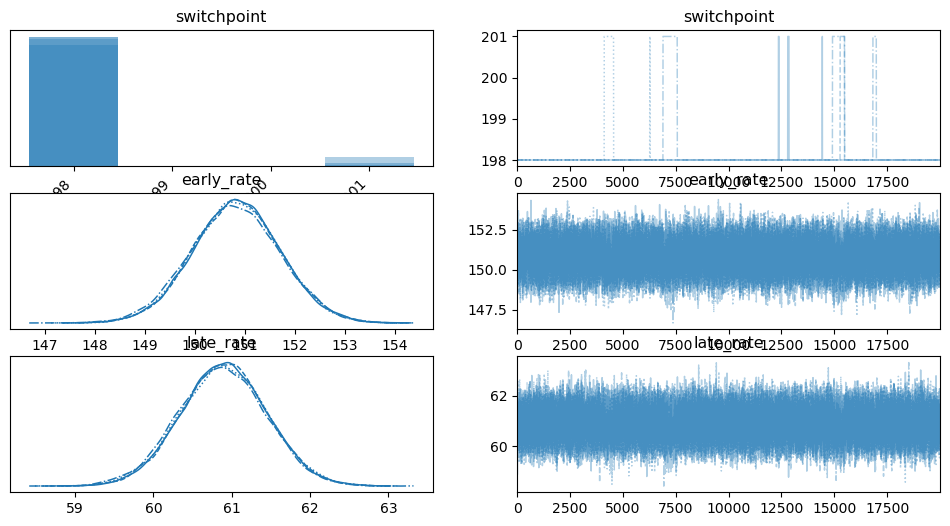

In [11]:
axes_arr = pm.plot_trace(idata)
plt.draw()

for ax in axes_arr.flatten():
    if ax.get_title() == "switchpoint":
        labels = [label.get_text() for label in ax.get_xticklabels()]
        ax.set_xticklabels(labels, rotation=45, ha="right")
        break
plt.draw()

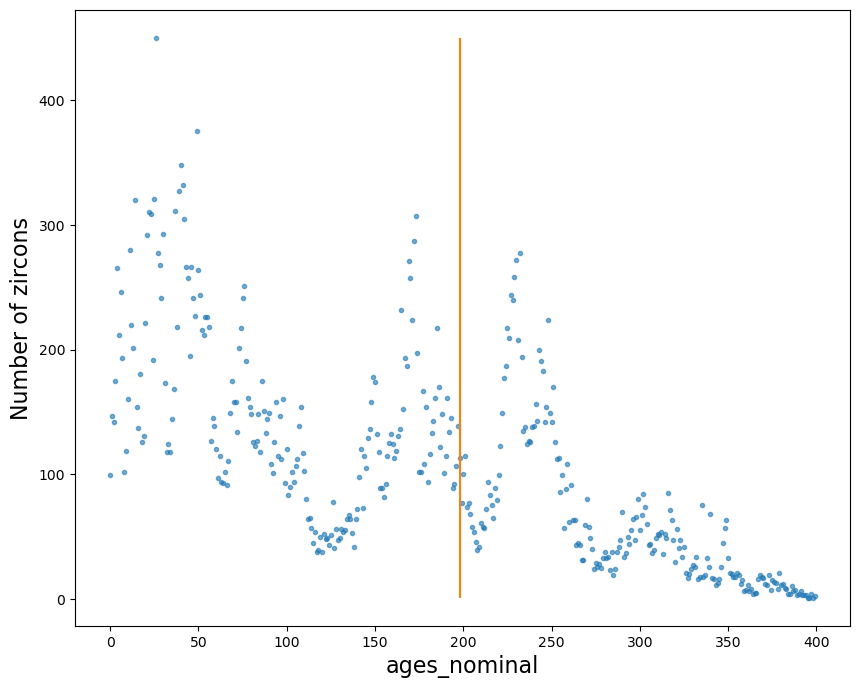

In [12]:
plt.figure(figsize=(10, 8))
plt.plot(ages_nominal, zircons_data, ".", alpha=0.6)
plt.ylabel("Number of zircons", fontsize=16)
plt.xlabel("ages_nominal", fontsize=16)

trace = idata.posterior.stack(draws=("chain", "draw"))

plt.vlines(trace["switchpoint"].mean(), zircons_data.min(), zircons_data.max(), color="C1")
#average_zircons = np.zeros_like(zircons_data, dtype="float")
#for i, year in enumerate(ages_nominal):
    #idx = year < trace["switchpoint"]
   # average_zircons[i] = np.mean(np.where(idx, trace["early_rate"], trace["late_rate"]))

#sp_hpd = az.hdi(idata, var_names=["switchpoint"])["switchpoint"].values
#plt.fill_betweenx(
   # y=[zircons_data.min(), zircons_data.max()],
   # x1=sp_hpd[0],
    #x2=sp_hpd[1],
    #alpha=0.5,
    #color="C1",
#)
#plt.plot(ages_nominal, average_zircons, "k--", lw=2);

In [13]:
trace = idata.posterior.stack(draws=("chain", "draw"))
trace

<xarray.Dataset>
Dimensions:      (draws: 80000)
Coordinates:
  * draws        (draws) object MultiIndex
  * chain        (draws) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw         (draws) int64 0 1 2 3 4 5 ... 19995 19996 19997 19998 19999
Data variables:
    switchpoint  (draws) int64 198 198 198 198 198 198 ... 198 198 198 198 198
    early_rate   (draws) float64 151.3 150.3 152.2 150.0 ... 149.6 150.6 150.8
    late_rate    (draws) float64 60.45 61.62 61.57 60.1 ... 60.25 60.39 60.51
Attributes:
    created_at:                 2023-08-07T08:56:01.539001
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.7.1
    sampling_time:              26.433273792266846
    tuning_steps:               1000

In [14]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
switchpoint,198.08,0.49,198.00,198.00,0.04,0.03,171.74,171.74,1.02
early_rate,150.82,0.88,149.17,152.47,0.01,0.01,10693.89,15076.66,1.00
late_rate,60.89,0.55,59.84,61.92,0.01,0.00,8420.83,11551.40,1.00
